<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/7_exploring_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. Hybrid modelling - Integrating ML with process-based simulations

In this series of workshops we have shown how ML models can effectively learn from any data that we feed them. However, in science, a large corpus of knowledge has been acquired in the form of equations and other theoretical knowledge. It would be great to use that knowledge to inform our ML models, allowing them to improve their predictions, right? That's exactly what we are going to do by exploring the world of hybrid modelling; models that combine process-based simulations with machine learning models to (hopefully) improve both.

## 8.1 Introduction to hybrid modelling

### Why Hybrid Models?
Integrating scientific knowledge with machine learning models offers several advantages:
-  Consistency with physical knowledge: ML models can violate physical laws (e.g., conservation of mass). Hybrid models can enforce these as either soft or hard constraints.
-  Smaller data requirements: Physical models provide a strong prior, reducing the amount of observational training data needed for the ML component.
-  Extrapolation: Physical models typically generalize better to unseen conditions (e.g., climate change scenarios) than pure ML models.

If we look it from the perspective of process-based models, hybrid models still offer most of the advantages of ML, namely a good fit to the observations and higher speed compared to highly detailed physical models.

### Introducing Scientific Knowledge
There are three main ways to introduce scientific knowledge into ML ([Willard et al., 2023](https://doi.org/10.1145/3514228)):
1.  **Loss Function**: Adding physical constraints (e.g., energy conservation) to the loss function.
2.  **Initialization**: Initialize the model weights according to knowledge of the system, then fine-tuning on observations. We will focus on this approach.
3.  **Architecture**: Designing the neural network architecture to reflect physical processes (e.g., mass balance layers).

There is yet another way in which we represent our scientific knowledge, and it is through the process-based (or physical) models. Instead of engraining the scientific knowledge into the ML structure, we can also "connect" a ML component to a physical model so that they run together, yet independently. This is what is commonly known as **hybrid modelling**.

### Types of Hybrid Models 
The ML component in a hybrid model can be used for different tasks ([Reichstein et al., 2019](https://doi.org/10.1038/s41586-019-0912-1)):
1.  **Improving Parameterizations**: Using ML to estimate parameterizations for physical models.
2.  **Replacing a Sub-model**: Replacing a computationally expensive or poorly understood physical process with an ML model.
3.  **Model-Observation Mismatch**: Using ML to correct the errors of a physical model.
4.  **Constraining Submodels**: Using ML to replace a coupled sub-model to disentangle its errors.
5.  **Surrogate Modelling**: Emulating the entire physical model with ML for speed.

For this workshop we will focus on improving the performance of our target variable in process-based simulations, that is, on the model-observation mismatch.

## 8.2 Problem Description and Data

We aim to predict streamflow at Basel. We will use the same dataset as in the first workshop, which includes meteorological variables (precipitation, temperature, evapotranspiration) and the observed discharge at Basel.

![picture](images/basel_discharge.jpg)

Additionally, we will use the simulated discharge from the **PCR-GLOBWB** global hydrological model. PCR-GLOBWB simulates the water cycle based on physical equations. We will use its output ('pcr') as a representation of physical knowledge.

We first import the necessary libraries and load the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Load data
input_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/pred_basel.csv", delimiter=",", on_bad_lines='skip', index_col=0)
output_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/q_basel.csv", delimiter = ",", on_bad_lines='skip', index_col=0)

# Select variables, including the physical model output 'pcr'
# Note: We assume the column 'pcr' exists in the input dataset representing the PCR-GLOBWB simulation.
input_data = input_data[['p', 't', 'et']]
output_data = output_data[['obs', 'pcr']]

# Drop missing values
combined = pd.concat([input_data, output_data], axis=1).dropna()
input_data = combined[['p', 't', 'et', 'pcr']]
output_data = combined[['obs']]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, shuffle=False)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 6574, Test samples: 731


### Baseline: PCR-GLOBWB Performance

Before building any hybrid models, it is important to establish a baseline. How well does the physical model (PCR-GLOBWB) perform on its own?

In [2]:
# Evaluate PCR-GLOBWB directly
pcr_r2 = r2_score(y_test, X_test['pcr'])
pcr_rmse = root_mean_squared_error(y_test, X_test['pcr'])

print("Physical Model Performance (PCR-GLOBWB):")
print(f"R2: {pcr_r2:.3f}")
print(f"RMSE: {pcr_rmse:.3f}")

Physical Model Performance (PCR-GLOBWB):
R2: 0.227
RMSE: 487.852


## 8.3 Hybrid Modelling under Data Scarcity

We will first explore a scenario of **data scarcity**. Imagine we have a physical model (PCR-GLOBWB) that provides simulations for the entire period, but we only have a few real-world observations of discharge to train our ML models. To simulate that scenario, we will select only 5% of the trainig data as available observations.

We will compare three approaches:
1.  **Pure ML**: Trained only on the few available observations.
2.  **Initialization**: Pre-trained on the abundant physical model simulations, producing a surrogate model that is then fine-tuned on the fewer observations.
3. **Data augmentation**: Trained on both the physical model simulations and few observations at the same time. 

In [13]:
# Simulate Data Scarcity by using only 5% of the "observed" training data
X_train_scarce = X_train.sample(frac=0.05, random_state=42)
y_train_scarce = y_train.loc[X_train_scarce.index]

print(f"Full Training samples: {len(X_train)}")
print(f"Scarce Training samples: {len(X_train_scarce)}")

Full Training samples: 6574
Scarce Training samples: 329


### Pure ML Model (Scarce Data)

First, we train a standard Neural Network approach, the MLP regressor, using only the scarce meteorological inputs. This model has to learn the rainfall-runoff relationship from very few examples, making it a very difficult task for traditional ML approaches.

In [14]:
# Train MLP Regressor with ONLY scarce meteo inputs
X_train_meteo_scarce = X_train_scarce[['p', 't', 'et']]
X_test_meteo = X_test[['p', 't', 'et']]

model_pure = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
model_pure.fit(X_train_meteo_scarce, y_train_scarce.values.ravel())

# Predict
pred_pure = model_pure.predict(X_test_meteo)

# Evaluate
pure_r2 = r2_score(y_test, pred_pure)
pure_rmse = root_mean_squared_error(y_test, pred_pure)

print("Pure ML Model (Scarce) Performance:")
print(f"R2: {pure_r2:.3f}")
print(f"RMSE: {pure_rmse:.3f}")

Pure ML Model (Scarce) Performance:
R2: -0.079
RMSE: 576.583


### Initialization (pre-training)

Now we use the Initialization approach.
1.  **Pre-training**: We use the **full** set of physical model simulations (`X_train['pcr']`) to pre-train the network. This can be used when we have longer time series of simulated data, but also to train in extreme conditions not available in the observations or even for extrapolating to different stations. The more accurate the physical model, the better.
2.  **Fine-tuning**: We then fine-tune the network using only the **scarce** observed data (`y_train_scarce`). In the ML world, pre-training a model on a similar task for which we have more data and fine-tuning on a small number of observsations is called *Transfer Learning*. In this case we simply fit again the pre-trained NN to the new data.


In [15]:
# Initialize MLP Regressor
# warm_start=True allows us to continue training
model_init = MLPRegressor(hidden_layer_sizes=(64, 64), random_state=42, max_iter=1000, warm_start=True)

# Step 1: Pre-train on PCR-GLOBWB output
# We want the model to learn the mapping from Meteo -> PCR
print("Pre-training on Physical Model...")
model_init.fit(X_train[['p', 't', 'et']], X_train['pcr'])

# Check how well it learned PCR
pcr_pred_init = model_init.predict(X_test[['p', 't', 'et']])
init_pcr_r2 = r2_score(X_test['pcr'], pcr_pred_init)
print(f"Pre-training R2 on PCR: {init_pcr_r2:.3f}")

Pre-training on Physical Model...
Pre-training R2 on PCR: 0.206


In [16]:
# Step 2: Fine-tune on Scarce Observed Data
print("Fine-tuning on Scarce Observations...")
model_init.fit(X_train_meteo_scarce, y_train_scarce.values.ravel())

# Predict
pred_init = model_init.predict(X_test_meteo)

# Evaluate
init_r2 = r2_score(y_test, pred_init)
init_rmse = root_mean_squared_error(y_test, pred_init)

print("Initialization (Scarce) Performance:")
print(f"R2: {init_r2:.3f}")
print(f"RMSE: {init_rmse:.3f}")

Fine-tuning on Scarce Observations...
Initialization (Scarce) Performance:
R2: -0.056
RMSE: 570.263


### Data Augmentation

Lastly, we train using a Data Augmentation approach, where we use the same data as before but using both sources to train the model at the same time, speeding up the process. However, it offers less customization and control over the training process. To balance the impact of both data sources, a weight can be added to the loss function to compensate for the smaller number of observations.

In [19]:
# Train a RF model on a concatenation of both observed and PCR outputs
X_train_augmented = pd.concat([X_train_meteo_scarce, X_train[['p', 't', 'et']]], axis=0, ignore_index=True)
y_train_augmented = pd.concat([y_train_scarce.squeeze(), X_train['pcr']], axis=0, ignore_index=True)

model_augmented = MLPRegressor(hidden_layer_sizes=(64, 64), random_state=42, max_iter=1000, warm_start=True)
model_augmented.fit(X_train_augmented, y_train_augmented.values.ravel())

# Predict
pred_augmented = model_augmented.predict(X_test_meteo)

# Evaluate
augmented_r2 = r2_score(y_test, pred_augmented)
augmented_rmse = root_mean_squared_error(y_test, pred_augmented)

print("Data Augmentation (Scarce) Performance:")
print(f"R2: {augmented_r2:.3f}")
print(f"RMSE: {augmented_rmse:.3f}")

Data Augmentation (Scarce) Performance:
R2: 0.132
RMSE: 517.036


### Comparison

Comparison under Data Scarcity:


,Model,R2,RMSE
0,Pure ML (Scarce),-0.079109,576.583037
1,Initialization (Scarce),-0.055581,570.262740
2,Augmented (Scarce),0.132273,517.035967


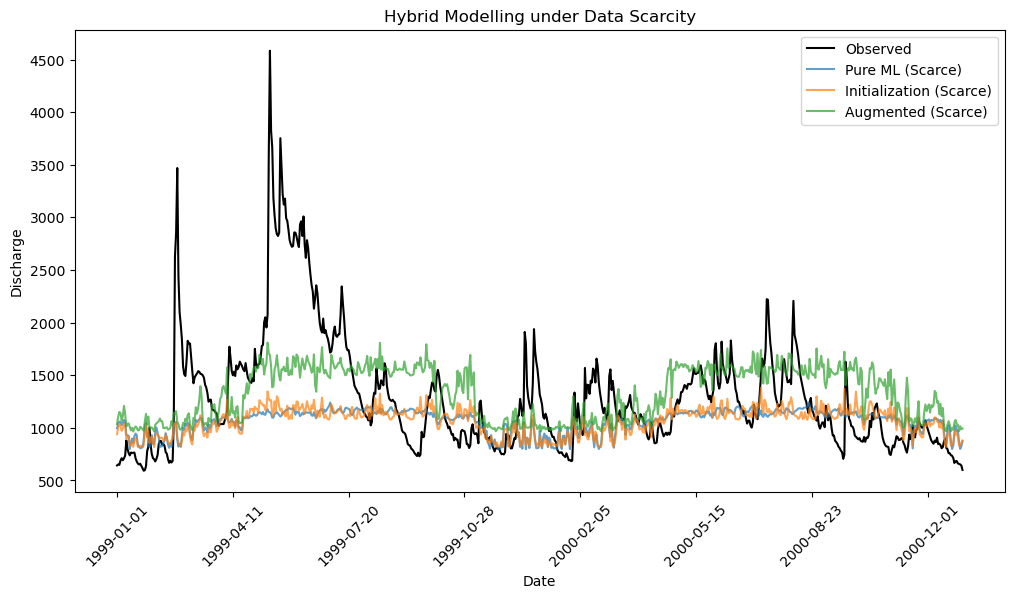

In [20]:
# Compare Pure ML (Scarce) vs Initialization (Scarce)
print("Comparison under Data Scarcity:")
display(pd.DataFrame({
    'Model': ['Pure ML (Scarce)', 'Initialization (Scarce)', 'Augmented (Scarce)'],
    'R2': [pure_r2, init_r2, augmented_r2],
    'RMSE': [pure_rmse, init_rmse, augmented_rmse]
}))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test['obs'], label='Observed', color='black')
plt.plot(y_test.index, pred_pure, label='Pure ML (Scarce)', alpha=0.7)
plt.plot(y_test.index, pred_init, label='Initialization (Scarce)', alpha=0.7)
plt.plot(y_test.index, pred_augmented, label='Augmented (Scarce)', alpha=0.7)
plt.legend()
plt.title('Hybrid Modelling under Data Scarcity')
plt.ylabel('Discharge')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.show()

## 8.4 Hybrid Modelling for Error Correction

In this section, we assume we have access to the **full** set of observed data. We want to see if combining the physical model with ML can outperform a pure ML model trained on the same full dataset. This time, since we don't need to re-train, we will use a Random Forest. We will explore three methods:

1.  **Pure ML**: Trained on all available observations.
2.  **Input Coupling**: Using the physical model output as an input feature.
3.  **Residual Modelling**: Predicting the error (residual) of the physical model.

### Pure ML Model (Full Data)

In [9]:
# Train Random Forest with FULL meteo inputs
X_train_meteo_full = X_train[['p', 't', 'et']]

model_pure_full = RandomForestRegressor(random_state=42)
model_pure_full.fit(X_train_meteo_full, y_train.values.ravel())

# Predict
pred_pure_full = model_pure_full.predict(X_test_meteo)

# Evaluate
pure_full_r2 = r2_score(y_test, pred_pure_full)
pure_full_rmse = root_mean_squared_error(y_test, pred_pure_full)

print("Pure ML Model (Full Data) Performance:")
print(f"R2: {pure_full_r2:.3f}")
print(f"RMSE: {pure_full_rmse:.3f}")

Pure ML Model (Full Data) Performance:
R2: 0.073
RMSE: 534.503


### Input Coupling

This is the simplest approach where we still want to predict our target, streamflow, based on the meteological variables, but to make this task easier we provide our ML model with the process-based model prediction of streamflow on that time step as an additional input so that the ML model learns to correct it.

In [10]:
# Train Random Forest with p, t, et, AND pcr as inputs
model_input = RandomForestRegressor(random_state=42)
model_input.fit(X_train, y_train.values.ravel())

# Predict
pred_input = model_input.predict(X_test)

# Evaluate
input_r2 = r2_score(y_test, pred_input)
input_rmse = root_mean_squared_error(y_test, pred_input)

print("Method 1 (Input Coupling) Performance:")
print(f"R2: {input_r2:.3f}")
print(f"RMSE: {input_rmse:.3f}")

Method 1 (Input Coupling) Performance:
R2: 0.568
RMSE: 365.005


### Residual modelling
Sometimes the goal can be more nuanced, for example to discover the limitations and biases of the process-based model. In that case, we can fit the residual of the process-based model (that is, its "error" with respect to the observations) as our target given the same inputs. We could even check the feature importances to have more insights on which model components need most improvement.

In [11]:
# Calculate Residuals (Observed - Physical Model)
residuals_train = y_train['obs'] - X_train['pcr']

# Train Random Forest to predict residuals from meteo data
model_resid = RandomForestRegressor(random_state=42)
model_resid.fit(X_train_meteo_full, residuals_train)

# Predict residuals on test set
pred_residuals = model_resid.predict(X_test_meteo)

# Final prediction = Physical Model + Predicted Residual
pred_resid_model = X_test['pcr'] + pred_residuals

# Evaluate
resid_r2 = r2_score(y_test, pred_resid_model)
resid_rmse = root_mean_squared_error(y_test, pred_resid_model)

print("Residual Modelling Performance:")
print(f"R2: {resid_r2:.3f}")
print(f"RMSE: {resid_rmse:.3f}")

Residual Modelling Performance:
R2: 0.565
RMSE: 366.222


### Comparison

Comparison for Error Correction:


,Model,R2,RMSE
0,Pure ML (Full),0.072655,534.502771
1,Input Coupling,0.567547,365.004687
2,Residual Modelling,0.564658,366.221921


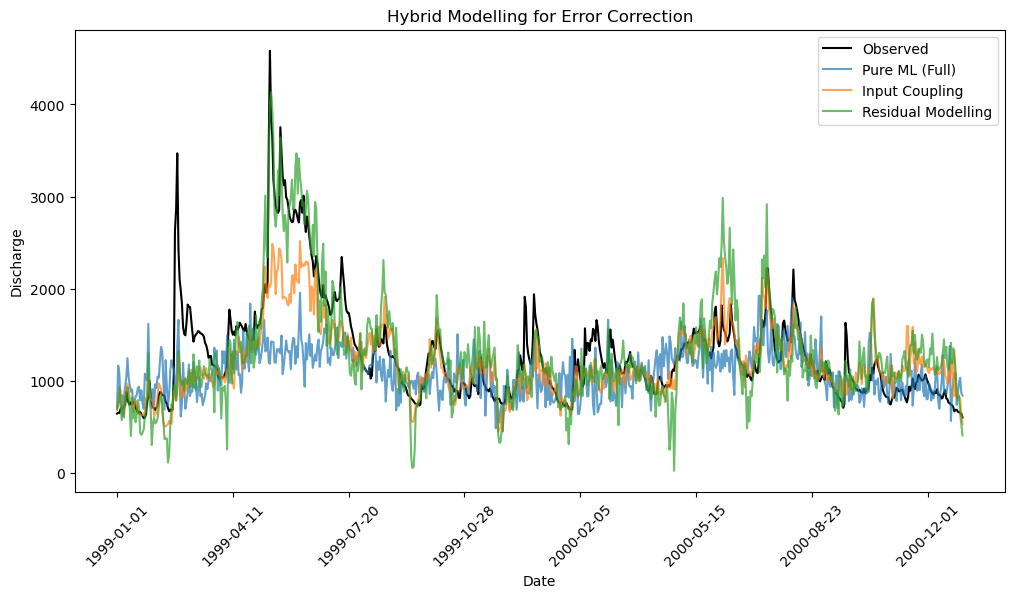

In [12]:
# Compare Pure ML (Full), Input Coupling, and Residual Modelling
print("Comparison for Error Correction:")
display(pd.DataFrame({
    'Model': ['Pure ML (Full)', 'Input Coupling', 'Residual Modelling'],
    'R2': [pure_full_r2, input_r2, resid_r2],
    'RMSE': [pure_full_rmse, input_rmse, resid_rmse]
}))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test['obs'], label='Observed', color='black')
plt.plot(y_test.index, pred_pure_full, label='Pure ML (Full)', alpha=0.7)
plt.plot(y_test.index, pred_input, label='Input Coupling', alpha=0.7)
plt.plot(y_test.index, pred_resid_model, label='Residual Modelling', alpha=0.7)
plt.legend()
plt.title('Hybrid Modelling for Error Correction')
plt.ylabel('Discharge')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.show()

## 8.5 Final remarks

It is often that the data-driven models, such as ML, and the process-based or physical models are seen as two antagonistic methodologies. Here we have seen how hybrid models that combine both can be used to improve 1) ML performance when working with few observational data and 2) the fit of proces-based model simulations to the observations. The optimal hybrid implementation and final performance will depend on the task, data, available models and sources of scientific knowledge, but the high appeal of such techniques have increased the popularity of hybrid models in the recent years, making it a fast-developing field. Stay in tune for future workshops on other ways to include scientific knowledge into ML!

Finally, to get some hands-on experience into hybrid model building, we propose this small exercise. For the Input Coupling technique we only used the simulated target variable (discharge) as input. However, some studies (e.g., [Magni et al., 2023](https://doi.org/10.2166/hydro.2023.217)) have shown that introducing additional state variables from the process-based model can further improve the performance of such hybrid models. Test adding a few more of the variables available at the [source data](https://github.com/oriol-pomarol/final_thesis_project/blob/main/data/pred_basel.csv) and see what is the effect on the performance.



In [ ]:
# Load data and select additional input variables (e.g., "baseflow", "surfaceWaterStorage"...)


# Split into train and test sets


# Train a RF with the additional inputs


# Predict on the test set and evaluate performance

